<a href="https://colab.research.google.com/github/abhishek150220/Generative-AI-Lab/blob/main/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Name :- Abhishek Kumar
## Scholar No. :- 25215011111
## Lab No.:- 1
## Topic Name :- Human Activity Recognition (HAR) using WISDM Dataset

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

In [34]:
# 2. LOAD DATASET

file_path = "/content/WISDM_ar_v1.1_raw.txt"

columns = ['user', 'activity', 'timestamp', 'x', 'y', 'z']

data = pd.read_csv(
    file_path,
    header=None,
    names=columns,
    comment=';',
    on_bad_lines='skip'
)

data = data.dropna()

data['x'] = data['x'].astype(float)
data['y'] = data['y'].astype(float)
data['z'] = data['z'].astype(float)

activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
data = data[data['activity'].isin(activities)]

print("Dataset shape:", data.shape)

Dataset shape: (128904, 6)


In [35]:
# 3. SLIDING WINDOW SEGMENTATION (FIXED)

WINDOW_SIZE = 128
STEP_SIZE = 64

segments = []
labels = []

for i in range(0, len(data) - WINDOW_SIZE, STEP_SIZE):
    x = data['x'].iloc[i:i+WINDOW_SIZE].values
    y = data['y'].iloc[i:i+WINDOW_SIZE].values
    z = data['z'].iloc[i:i+WINDOW_SIZE].values

    # Correct label assignment
    label = data['activity'].iloc[i:i+WINDOW_SIZE].mode()[0]

    segment = np.dstack((x, y, z))[0]
    segments.append(segment)
    labels.append(label)

X = np.array(segments)
y = np.array(labels)

print("Segmented data shape:", X.shape)
print("Labels shape:", y.shape)

Segmented data shape: (2013, 128, 3)
Labels shape: (2013,)


In [36]:
# 4. LABEL ENCODING

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [37]:
# 5. TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [38]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(WINDOW_SIZE, 3)),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(encoder.classes_), activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 126, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,508 (1.97 MB)

 Trainable params: 517,508 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 7. TRAIN MODEL

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4456 - loss: 2.6486 - val_accuracy: 0.7236 - val_loss: 0.5924
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7396 - loss: 0.6387 - val_accuracy: 0.8665 - val_loss: 0.3705
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8454 - loss: 0.4256 - val_accuracy: 0.8789 - val_loss: 0.2652
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8780 - loss: 0.3201 - val_accuracy: 0.9193 - val_loss: 0.2131
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8809 - loss: 0.2788 - val_accuracy: 0.9224 - val_loss: 0.1710
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9264 - loss: 0.1889 - val_accuracy: 0.9193 - val_loss: 0.1537
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9518 - loss: 0.1419 - val_accuracy: 0.9441 - val_loss: 0.1330
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9595 - loss: 0.1262 - val_accuracy: 0.9596 - v

In [42]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 126, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       491,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,508 (1.97 MB)

 Trainable params: 517,508 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
# 8. EVALUATION

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true, y_pred_classes)
print("Test Accuracy:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Accuracy: 0.9900744416873449


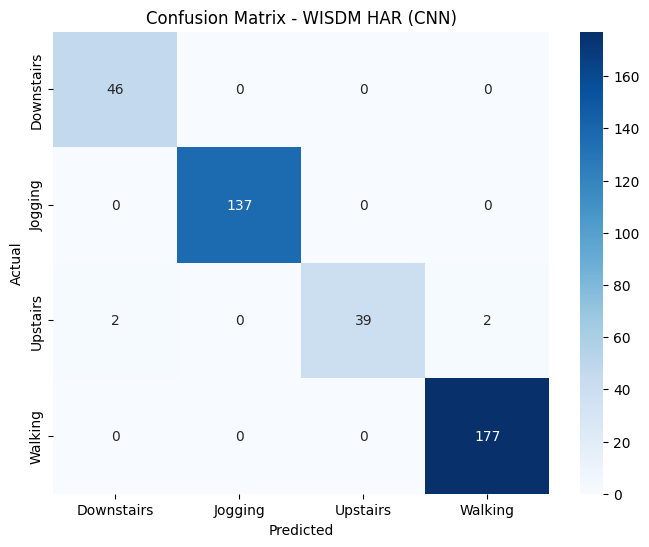

In [44]:
# 9. CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - WISDM HAR (CNN)")
plt.show()